In [1]:
import pandas as pd
import geopandas as gpd
import os
import re
import matplotlib.pyplot as plt
print(os.getcwd())
os.chdir(r"C:\Users\LMENENDEZ\GitHub\MultiModX")
print(os.getcwd())
pd.set_option('display.max_columns', None)

c:\Users\LMENENDEZ\GitHub\MultiModX\notebooks
C:\Users\LMENENDEZ\GitHub\MultiModX


NOTE: I might want to remove the legs column in the future 

Some characteristics of the trips that go abroad:
- if the person is spanish: we know the "roaming out", i.e., the signal they emitted when they connect to roaming. Hence we know with certainty the country where they arrived. However, if they did a connection, we only know the country where they first connected. We have to assume that that is their final destination
- if the person is not spanish, we assume their country of destination is their origin country. 
For trips that come from abroad a similar situation holds

This might create inaccuracies in the results


# 1. Format and eliminate unnecessary trips

In [2]:
# Trips during the week 22/09/2022 28/09/2022 (thursday to thursday)
# the day of study selected was Friday to put the air layer under pressure
all_trips = pd.read_csv(
    r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\Matrices MITMA\with_archetypes\20220922_28_trip_matrix_arc_pt_processed.csv.gz",
    compression="gzip",
    sep="|"
)

In [3]:
#Here there is no trip id but later trip id appears all the time
trips = all_trips[all_trips["date"] == 20220923].reset_index(drop=True).rename(columns={"origin_nut": "origin", "destination_nut": "destination"})
trips.head()

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced
0,20220923,P00,01002,ES211,Álava,4802006,ES213,Vizcaya,NaN,NaN,NF,O,D04_[10000-50000),D04_[10000-50000),01-02,train,conv_unknown,P00*01002*01002*None*train_13121*00-01*road*No...,other,ES,2_48,4801303,2_48,I01_[10000-15000),A01_[25-45),male,passenger,False,4.135,139.516,1.0,0.000000,0.000000,2.067500,2.067500,0.000000,0.000000,3,road-train-road,train_13121-train_13200,train_13121,train_13200,national,2,1,0,train_13121-train_13200,train_13106,train_13200
1,20220923,P00,01009_AM,ES211,Álava,31010_AM,ES220,Navarra,NaN,NaN,O,H,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*01009_AM*01009_AM*None*train_11213*00-01*r...,other,ES,2_31,31010_AM,2_31,I01_[10000-15000),A01_[25-45),male,passenger,False,5.191,69.312,1.0,3.707857,0.000000,0.000000,0.494381,0.000000,0.988762,3,road-train-road,train_11213-train_11300,train_11213,train_11300,national,2,1,0,train_11213-train_11300,train_13106,train_11300
2,20220923,P00,01009_AM,ES211,Álava,abroad_208,abroad,abroad,NaN,ground_Fra_08,NF,NF,abroad,D05_[50000-inf),01-02,train,conv_unknown,P00*01009_AM*01009_AM*None*train_11213*00-01*r...,other,FR,NaN,NaN,NaN,NaN,NaN,NaN,passenger,False,1.599,309.588,1.0,0.888333,0.399750,0.142133,0.071067,0.062183,0.035533,3,road-train-road,train_11213-train_11600,train_11213,train_11600,international_D,2,1,0,train_11213-train_11600,train_11208,train_11511
3,20220923,P00,01036,ES211,Álava,4802006,ES213,Vizcaya,NaN,NaN,H,O,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*01036*01036*None*train_13106*00-01*road*No...,other,ES,2_01,01036,2_48,I02_[15000-inf),A02_[45-65),female,passenger,False,6.236,139.477,1.0,3.118000,0.000000,0.779500,1.559000,0.779500,0.000000,3,road-train-road,train_13106-train_13200,train_13106,train_13200,national,2,1,0,train_13106-train_13200,train_13106,train_13200
4,20220923,P00,0105902,ES211,Álava,09219,ES412,Burgos,NaN,NaN,O,NF,D04_[10000-50000),D04_[10000-50000),01-02,train,conv_unknown,P00*0105902*0105901*None*train_11208*00-01*roa...,other,ES,2_01,0105904,2_01,I02_[15000-inf),A02_[45-65),male,passenger,False,4.215,155.813,1.0,3.417568,0.113919,0.227838,0.227838,0.227838,0.000000,3,road-train-road,train_11208-train_11200,train_11208,train_11200,national,2,1,0,train_11208-train_11200,train_11208,train_11200


In [4]:
%load_ext autoreload

In [5]:
%autoreload
from script.trips_format import *

In [6]:
#associates each airport to the corresponding new NUTS
airports_to_NUTS={"airport_LPA":("ES705","Gran Canaria"),
                 "airport_FUE":("ES704","Fuerteventura"),
                 "airport_ACE":("ES708","Lanzarote"),
                 "airport_TFS":("ES709","Tenerife"),
                 "airport_TFN":("ES709","Tenerife"),
                 "airport_GMZ":("ES709","Tenerife"),
                 "airport_SPC":("ES707","La Palma"),
                 "airport_VDE":("ES703","El Hierro"),
                 "airport_PMI":("ES532","Mallorca"),
                 "airport_IBZ":("ES531","Eivissa i Formentera"),
                 "airport_MAH":("ES533","Menorca")}

In [7]:
trips=format_trips(trips,airports_to_NUTS)

17 columns were removed


First we remove the cercanías trips and the trips that go through weird stations

In [8]:
# remove cercanías
trips=trips[~(((trips["origin"]=="ES424")&(trips["destination"]=="ES300"))|((trips["origin"]=="ES300")&(trips["destination"]=="ES424")))]

In [9]:
# location of "ALL" train stops given by UiC
# However this list is still incomplete
stops_loc=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\infrastructure\rail_info\stops.txt").astype(str) # everything is a string here to match other formatting
stops_loc["stop_id"] = stops_loc["stop_id"].apply(lambda x: "00" + x) #to make they start with 00

In [10]:
trips.loc[:,"weird_stations"] = trips["node_sequence_reduced"].apply(
    lambda x: find_weird_stations(x, stops_loc))

In [11]:
unique_weird_stations=get_weird_stations(trips["weird_stations"])

In [12]:
len(unique_weird_stations)

414

In [13]:
MobA_stations_coord=gpd.read_file(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\oferta_transporte\train_stations\train_stations.shp")

In [14]:
# identifies all the un-localisable stations
nowhere_stations=set(unique_weird_stations)-set(MobA_stations_coord["ID"])
print(f"there are {len(nowhere_stations)} stations that are not in the data provided by MobA but appear in the trips dataframe")

there are 205 stations that are not in the data provided by MobA but appear in the trips dataframe


In [15]:
trips = trips[~trips["node_sequence_reduced"].apply(lambda x: any(station in x for station in nowhere_stations))]

Then we add the relevant information for international trips

In [16]:
international_codes=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\infrastructure\countries mcc\mcc_to_nationality.txt", sep="|")
international_codes

,mcc,country_name,country
0,202,Greece,GR
1,204,Netherlands,NL
2,206,Belgium,BE
3,208,France,FR
4,212,Monaco,MC
...,...,...,...
227,746,Suriname,SR
228,748,Uruguay,UY
229,750,Falkland Islands (Malvinas),FK
230,901,International & Satellite Networks,-


In [17]:
mcc_to_country=international_codes.set_index("mcc")["country"].to_dict()

In [18]:
#it is better to divide trips into trips that go to or come from abroad and trips that do not come from
#or go to abroad to save time in computations

trips_abroad=trips[(trips["origin"]=="abroad")|(trips["destination"]=="abroad")]
trips_national=trips[~((trips["origin"]=="abroad")|(trips["destination"]=="abroad"))]

In [19]:
num_trips_to_fr=trips_abroad[trips_abroad["destination_zone"].str.startswith("FR")]["trips"].sum()
num_trips_from_fr=trips_abroad[trips_abroad["origin_zone"].str.startswith("FR")]["trips"].sum()
print(f"there are {num_trips_to_fr} trips to france and {num_trips_from_fr} trips from france")

there are 52771.643 trips to france and 38479.735 trips from france


In [20]:
num_trips_to_fr_plane=trips_abroad[(trips_abroad["destination_zone"].str.startswith("FR"))&((trips_abroad["exit_point"].str.startswith("airport",na=False)))]["trips"].sum()
num_trips_from_fr_plane=trips_abroad[(trips_abroad["origin_zone"].str.startswith("FR"))&((trips_abroad["entry_point"].str.startswith("airport",na=False)))]["trips"].sum()
print(f"from which {num_trips_to_fr_plane} trips to france are done via plane and {num_trips_from_fr_plane} trips from france are via plane")

from which 51182.648 trips to france are done via plane and 36977.703 trips from france are via plane


In [21]:
num_trips_to_pt=trips_abroad[trips_abroad["destination_zone"].str.startswith("PT")]["trips"].sum()
num_trips_from_pt=trips_abroad[trips_abroad["origin_zone"].str.startswith("PT")]["trips"].sum()
print(f"there are {num_trips_to_pt} trips to portugal and {num_trips_from_pt} trips from portugal")

there are 26108.620000000003 trips to portugal and 18912.512 trips from portugal


In [22]:
num_trips_to_pt_plane=trips_abroad[(trips_abroad["destination_zone"].str.startswith("PT"))&((trips_abroad["exit_point"].str.startswith("airport",na=False)))]["trips"].sum()
num_trips_from_pt_plane=trips_abroad[(trips_abroad["origin_zone"].str.startswith("PT"))&((trips_abroad["entry_point"].str.startswith("airport",na=False)))]["trips"].sum()
print(f"from which {num_trips_to_pt_plane} trips to portugal are done via plane and {num_trips_from_pt_plane} trips from portugal are via plane")

from which 25555.691999999995 trips to portugal are done via plane and 18369.4 trips from portugal are via plane


In [23]:
trips_abroad=format_trips_abroad(trips_abroad,mcc_to_country)

In [24]:
trips_national=format_trips_national(trips_national)

In [25]:
trips=pd.concat([trips_abroad,trips_national],ignore_index=True)

after a lot of work I have discovered that 
- most of the trips to france and portugal are categorised by FRddd or PTddd but not all
- if the trip is done by a Portuguese or French person it shows "abroad_ddd" where ddd is the 3 digit mcc code.
so if I count all trips starting with FR and PT before formatting and after formatting, I will not find the same number of trips!!! But all is good, I have verified that format_trips_abroad works as intended

In [26]:
trips

,date,origin,origin_name,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,legs,nationality,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,trips
0,20220923,AD,AD,ES512,Girona,airport_GRO,NaN,NF,NF,P17*abroad_213*17233_AM*None*airport_GRO*00-01...,AD,0.374079,0.668807,0.430757,0.022671,0.056679,0.034007,2,plane-road,airport_GRO,airport_GRO,airport_GRO,international_O,1,0,1,airport_GRO,airport_GRO,airport_GRO,['air'],1.587
1,20220923,AD,AD,ES512,Girona,airport_GRO,NaN,NF,NF,P20*abroad_213*17233_AM*None*airport_GRO*00-01...,AD,0.374079,0.668807,0.430757,0.022671,0.056679,0.034007,2,plane-road,airport_GRO,airport_GRO,airport_GRO,international_O,1,0,1,airport_GRO,airport_GRO,airport_GRO,['air'],1.587
2,20220923,AD,AD,ES514,Tarragona,airport_REU,NaN,NF,NF,P18*abroad_213*4312310_AD*None*airport_REU*00-...,AD,2.709353,3.928561,1.964281,0.406403,0.067734,0.338669,2,plane-road,airport_REU,airport_REU,airport_REU,international_O,1,0,1,airport_REU,airport_REU,airport_REU,['air'],9.415
3,20220923,AD,AD,ES514,Tarragona,airport_REU,NaN,NF,NF,P23*abroad_213*4312310_AD*None*airport_REU*00-...,AD,0.456691,0.662201,0.331101,0.068504,0.011417,0.057086,2,plane-road,airport_REU,airport_REU,airport_REU,international_O,1,0,1,airport_REU,airport_REU,airport_REU,['air'],1.587
4,20220923,AD,AD,ES523,Valencia / València,airport_VLC,NaN,NF,NF,P13*abroad_213*4615903*None*airport_VLC*00-01*...,AD,4.090123,3.279816,1.813545,0.000000,0.115758,0.115758,2,plane-road,airport_VLC,airport_VLC,airport_VLC,international_O,1,0,1,airport_VLC,airport_VLC,airport_VLC,['air'],9.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208605,20220923,ES709,Tenerife,ES709,Tenerife,NaN,airport_TFS,W,NF,P21*38017*38017*None*airport_TFS*None*road*Non...,ES,1.138560,2.652846,0.307411,0.159398,0.056928,0.113856,2,road-plane,airport_TFS,airport_TFS,airport_TFS,international_D,1,0,1,airport_TFS,airport_TFS,airport_TFS,['air'],4.429
208606,20220923,ES709,Tenerife,ES709,Tenerife,NaN,airport_TFS,W,NF,P21*38035_AM*38017*None*airport_TFS*None*road*...,ES,0.889629,1.685613,0.171683,0.093645,0.015608,0.046823,2,road-plane,airport_TFS,airport_TFS,airport_TFS,international_D,1,0,1,airport_TFS,airport_TFS,airport_TFS,['air'],2.903
208607,20220923,ES709,Tenerife,ES709,Tenerife,NaN,airport_TFS,W,NF,P22*38035_AM*38017*None*airport_TFS*None*road*...,ES,1.085560,3.398276,0.519181,0.141595,0.188793,0.141595,2,road-plane,airport_TFS,airport_TFS,airport_TFS,international_D,1,0,1,airport_TFS,airport_TFS,airport_TFS,['air'],5.475
208608,20220923,ES709,Tenerife,ES709,Tenerife,NaN,airport_TFS,W,NF,P23*38017*38017*None*airport_TFS*None*road*Non...,ES,1.182374,3.472288,0.434036,0.149668,0.029934,0.134701,2,road-plane,airport_TFS,airport_TFS,airport_TFS,international_D,1,0,1,airport_TFS,airport_TFS,airport_TFS,['air'],5.403


# 2. Analysis of trips going abroad

We can distinguish the region in France and Portugal where the trip finishes, however we do not have the same level of detail with the rest of the countries, so we want to group those trips. 

In [27]:
trips_from_abroad=trips[~(trips["origin"].str.startswith("ES"))]

In [28]:
trips_to_abroad=trips[~(trips["destination"].str.startswith("ES"))]

In [29]:
trips_abroad

,date,origin,origin_name,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,legs,nationality,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,trips
0,20220923,AD,AD,ES512,Girona,airport_GRO,NaN,NF,NF,P17*abroad_213*17233_AM*None*airport_GRO*00-01...,AD,0.374079,0.668807,0.430757,0.022671,0.056679,0.034007,2,plane-road,airport_GRO,airport_GRO,airport_GRO,international_O,1,0,1,airport_GRO,airport_GRO,airport_GRO,['air'],1.587
1,20220923,AD,AD,ES512,Girona,airport_GRO,NaN,NF,NF,P20*abroad_213*17233_AM*None*airport_GRO*00-01...,AD,0.374079,0.668807,0.430757,0.022671,0.056679,0.034007,2,plane-road,airport_GRO,airport_GRO,airport_GRO,international_O,1,0,1,airport_GRO,airport_GRO,airport_GRO,['air'],1.587
2,20220923,AD,AD,ES514,Tarragona,airport_REU,NaN,NF,NF,P18*abroad_213*4312310_AD*None*airport_REU*00-...,AD,2.709353,3.928561,1.964281,0.406403,0.067734,0.338669,2,plane-road,airport_REU,airport_REU,airport_REU,international_O,1,0,1,airport_REU,airport_REU,airport_REU,['air'],9.415
3,20220923,AD,AD,ES514,Tarragona,airport_REU,NaN,NF,NF,P23*abroad_213*4312310_AD*None*airport_REU*00-...,AD,0.456691,0.662201,0.331101,0.068504,0.011417,0.057086,2,plane-road,airport_REU,airport_REU,airport_REU,international_O,1,0,1,airport_REU,airport_REU,airport_REU,['air'],1.587
4,20220923,AD,AD,ES523,Valencia / València,airport_VLC,NaN,NF,NF,P13*abroad_213*4615903*None*airport_VLC*00-01*...,AD,4.090123,3.279816,1.813545,0.000000,0.115758,0.115758,2,plane-road,airport_VLC,airport_VLC,airport_VLC,international_O,1,0,1,airport_VLC,airport_VLC,airport_VLC,['air'],9.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72720,20220923,ZA,ZA,ES300,Madrid,airport_MAD,NaN,NF,NF,P10*abroad_655*2807921*None*airport_MAD*00-01*...,ZA,2.200508,0.555165,0.660959,0.027204,0.123930,0.031234,2,plane-road,airport_MAD,airport_MAD,airport_MAD,international_O,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],3.599
72721,20220923,ZA,ZA,ES300,Madrid,airport_MAD,NaN,NF,NF,P19*abroad_655*2807921*None*airport_MAD*00-01*...,AR,5.411086,1.365160,1.625308,0.066895,0.304745,0.076806,2,plane-road,airport_MAD,airport_MAD,airport_MAD,international_O,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],8.850
72722,20220923,ZA,ZA,ES511,Barcelona,airport_BCN,NaN,NF,NF,P07*abroad_655*0816904*None*airport_BCN*00-01*...,AR,1.372793,1.028286,0.975929,0.048168,0.104713,0.069111,4,plane-road-train-road,airport_BCN-train_72400-train_71801,airport_BCN,train_71801,international_O,2,1,1,airport_BCN,airport_BCN,airport_BCN,"['air', 'rail']",3.599
72723,20220923,ZA,ZA,ES511,Barcelona,airport_BCN,NaN,NF,NF,P13*abroad_655*0816904*None*airport_BCN*00-01*...,ZA,1.372793,1.028286,0.975929,0.048168,0.104713,0.069111,2,plane-road,airport_BCN,airport_BCN,airport_BCN,international_O,1,0,1,airport_BCN,airport_BCN,airport_BCN,['air'],3.599


In [30]:
(trips_abroad["trips"].sum()/trips["trips"].sum())*100

np.float64(32.05073516016099)

32.05% of trips from my matrix either come from abroad or go abroad

In [31]:
trips_to_abroad[trips_to_abroad["destination"]=="DE"]["trips"].sum()

np.float64(4239.057)

In [32]:
outgoing_grouped=trips_to_abroad.groupby("destination")["trips"].sum().reset_index()

In [33]:
incoming_grouped=trips_from_abroad.groupby("origin")["trips"].sum().reset_index()

In [34]:
outgoing_grouped=outgoing_grouped.sort_values(by="trips",ascending=False)

In [35]:
incoming_grouped=incoming_grouped.sort_values(by="trips",ascending=False)

In [36]:
outgoing_grouped.head(10)

,destination,trips
36,FR,56012.453
85,PT,27449.514
37,GB,13017.612
105,US,4410.940
29,DE,4239.057
49,IT,4175.500
46,IE,3577.417
10,BE,3043.733
77,NL,2679.481
92,SE,1952.593


In [37]:
incoming_grouped.head(10)

,origin,trips
37,FR,44774.476
84,PT,21213.615
38,GB,14362.593
50,IT,7015.701
29,DE,5730.540
103,US,5515.558
47,IE,4328.649
10,BE,4190.503
76,NL,2983.813
62,MA,2491.248


The 10 countries where the people travel most to are:
1. France
2. Portugal
3. UK (Great Britain)
4. United States of America
5. Germany
6. Italy
7. Ireland
8. Belgium
9. The Netherlands
10. Sweden 

The 10 countries where people travel the most from are:
1. France
2. Portugal
3. UK (Great Britain)
4. Italy
5. Germany
6. United States of America
7. Ireland
8. Belgium
9. The Netherlands 
10. Morocco

# 3. Analysis of the international flight schedules

In [38]:
# download the flight schedules
flight_schedules=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\flights_schedules\flight_schedules_oag_es_v0.3.csv")

In [39]:
# the flights departing from each airport 
flights_capacity=flight_schedules.groupby(["origin","destination"])["seats"].sum().reset_index()

In [40]:
airports_info=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\infrastructure\airports_info\IATA_ICAO_Airport_codes_v1.3.csv")

In [41]:
spanish_airports=airports_info[airports_info["Country"]=="Spain"]

In [42]:
list_of_spanish_airports=list(spanish_airports["ICAO"])

In [43]:
def spanish_airport_checker(flights_capacity,list_of_spanish_airports):
    for idx, row in flights_capacity.iterrows():
        if row["origin"] not in list_of_spanish_airports and row["destination"] not in list_of_spanish_airports:
            print(f"the row {idx} does not contain any spanish airport")
    print("done!")

In [44]:
spanish_airport_checker(flights_capacity, list_of_spanish_airports)

done!


It seems that all flights already either come from spanish airports or go to spanish airports. 

In [45]:
#builds a dictionary of airports to country
airport_to_country=airports_info.set_index("ICAO")["Country"].to_dict()

In [46]:
flights_capacity["country_origin"]=flights_capacity["origin"].map(airport_to_country)

In [47]:
flights_capacity["country_destination"]=flights_capacity["destination"].map(airport_to_country)

In [48]:
flights_capacity.head()

,origin,destination,seats,country_origin,country_destination
0,BIKF,LEAL,186,Iceland,Spain
1,CYUL,LEBL,260,Canada,Spain
2,CYYZ,LEBL,282,Canada,Spain
3,CYYZ,LEMD,298,Canada,Spain
4,DAAG,LEAL,282,Algeria,Spain


In [49]:
flights_per_country=flights_capacity.groupby(["country_origin","country_destination"])["seats"].sum().reset_index()

In [50]:
flights_per_country=flights_per_country.drop(120)

In [51]:
flights_per_country=flights_per_country.sort_values(["seats"],ascending=False)

In [52]:
flights_per_country.head(7)

,country_origin,country_destination,seats
140,United Kingdom,Spain,89275
129,Spain,United Kingdom,88954
84,Spain,Germany,56441
26,Germany,Spain,56124
24,France,Spain,31438
82,Spain,France,31147
91,Spain,Italy,30510


In [53]:
flights_per_country_incoming=flights_per_country[flights_per_country["country_origin"]!="Spain"]

In [54]:
flights_per_country_outgoing=flights_per_country[flights_per_country["country_destination"]!="Spain"]

In [55]:
flights_per_country_incoming.head()

,country_origin,country_destination,seats
140,United Kingdom,Spain,89275
26,Germany,Spain,56124
24,France,Spain,31438
32,Italy,Spain,30392
44,Netherlands,Spain,16105


In [56]:
flights_per_country_outgoing.head()

,country_origin,country_destination,seats
129,Spain,United Kingdom,88954
84,Spain,Germany,56441
82,Spain,France,31147
91,Spain,Italy,30510
104,Spain,Netherlands,16329


In [57]:
# creates an equivalence acronym to country
country_to_acronym=international_codes.set_index("country_name")["country"].to_dict()

In [58]:
country_to_acronym["Russian Federation"]

'RU'

In [59]:
# some keys are not perfect, so I have to add this one by hand
country_to_acronym["USA"]="US"
country_to_acronym["Russia"]="RU"

In [60]:
flights_per_country_outgoing.loc[:,"destination_acronym"]=flights_per_country_outgoing.loc[:,"country_destination"].map(country_to_acronym)

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_2020\627038893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_per_country_outgoing.loc[:,"destination_acronym"]=flights_per_country_outgoing.loc[:,"country_destination"].map(country_to_acronym)


In [61]:
flights_per_country_outgoing.head()

,country_origin,country_destination,seats,destination_acronym
129,Spain,United Kingdom,88954,GB
84,Spain,Germany,56441,DE
82,Spain,France,31147,FR
91,Spain,Italy,30510,IT
104,Spain,Netherlands,16329,NL


In [62]:
flights_per_country_incoming.loc[:,"origin_acronym"]=flights_per_country_incoming.loc[:,"country_origin"].map(country_to_acronym)

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_2020\39015141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_per_country_incoming.loc[:,"origin_acronym"]=flights_per_country_incoming.loc[:,"country_origin"].map(country_to_acronym)


In [63]:
flights_per_country_incoming

,country_origin,country_destination,seats,origin_acronym
140,United Kingdom,Spain,89275,GB
26,Germany,Spain,56124,DE
24,France,Spain,31438,FR
32,Italy,Spain,30392,IT
44,Netherlands,Spain,16105,NL
...,...,...,...,...
29,Iceland,Spain,186,IS
36,Lebanon,Spain,180,LB
34,Jordan,Spain,133,JO
9,Cape Verde,Spain,100,CV


In [64]:
flights_per_country_incoming=flights_per_country_incoming.merge(incoming_grouped, left_on="origin_acronym",right_on="origin",how="left")

In [65]:
flights_per_country_incoming= flights_per_country_incoming.drop(["origin"],axis=1)

In [66]:
flights_per_country_incoming

,country_origin,country_destination,seats,origin_acronym,trips
0,United Kingdom,Spain,89275,GB,14362.593
1,Germany,Spain,56124,DE,5730.540
2,France,Spain,31438,FR,44774.476
3,Italy,Spain,30392,IT,7015.701
4,Netherlands,Spain,16105,NL,2983.813
...,...,...,...,...,...
63,Iceland,Spain,186,IS,127.824
64,Lebanon,Spain,180,LB,43.188
65,Jordan,Spain,133,JO,3.599
66,Cape Verde,Spain,100,CV,NaN


In [67]:
flights_per_country_outgoing=flights_per_country_outgoing.merge(outgoing_grouped, left_on="destination_acronym",right_on="destination",how="left")

In [68]:
flights_per_country_outgoing= flights_per_country_outgoing.drop(["destination"],axis=1)

In [69]:
flights_per_country_outgoing

,country_origin,country_destination,seats,destination_acronym,trips
0,Spain,United Kingdom,88954,GB,13017.612
1,Spain,Germany,56441,DE,4239.057
2,Spain,France,31147,FR,56012.453
3,Spain,Italy,30510,IT,4175.500
4,Spain,Netherlands,16329,NL,2679.481
...,...,...,...,...,...
70,Spain,Lebanon,180,LB,46.787
71,Spain,Moldova,138,MD,19.044
72,Spain,Jordan,133,JO,14.396
73,Spain,Cape Verde,100,CV,NaN


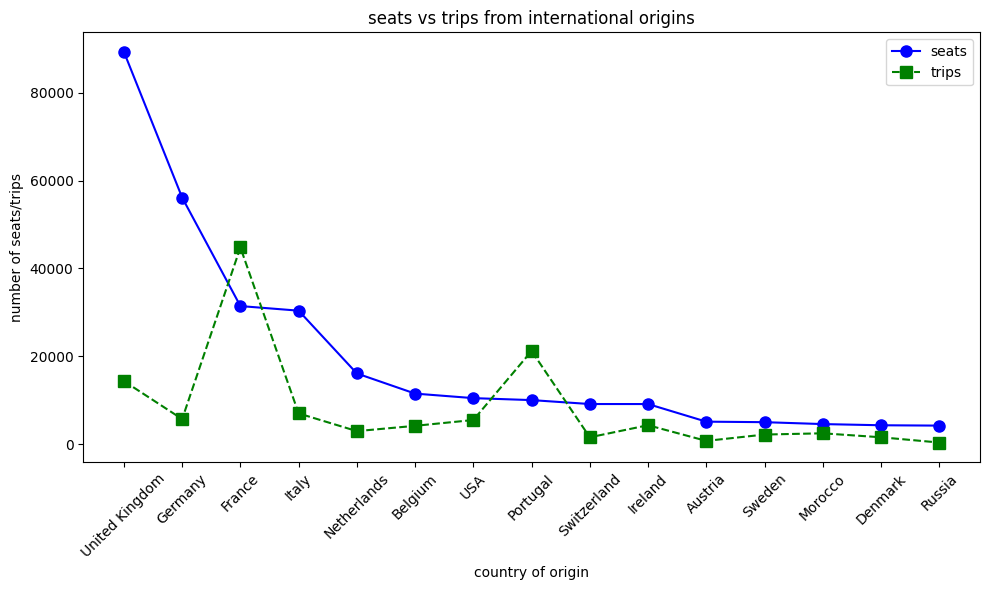

In [70]:
plt.figure(figsize=(10,6))

flights_per_country_incoming_first15=flights_per_country_incoming.head(15)

plt.plot(flights_per_country_incoming_first15["country_origin"],flights_per_country_incoming_first15["seats"],"bo-",label="seats",markersize=8)
plt.plot(flights_per_country_incoming_first15["country_origin"],flights_per_country_incoming_first15["trips"],"gs--",label="trips",markersize=8)

plt.xlabel("country of origin")
plt.ylabel("number of seats/trips")
plt.title("seats vs trips from international origins")

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

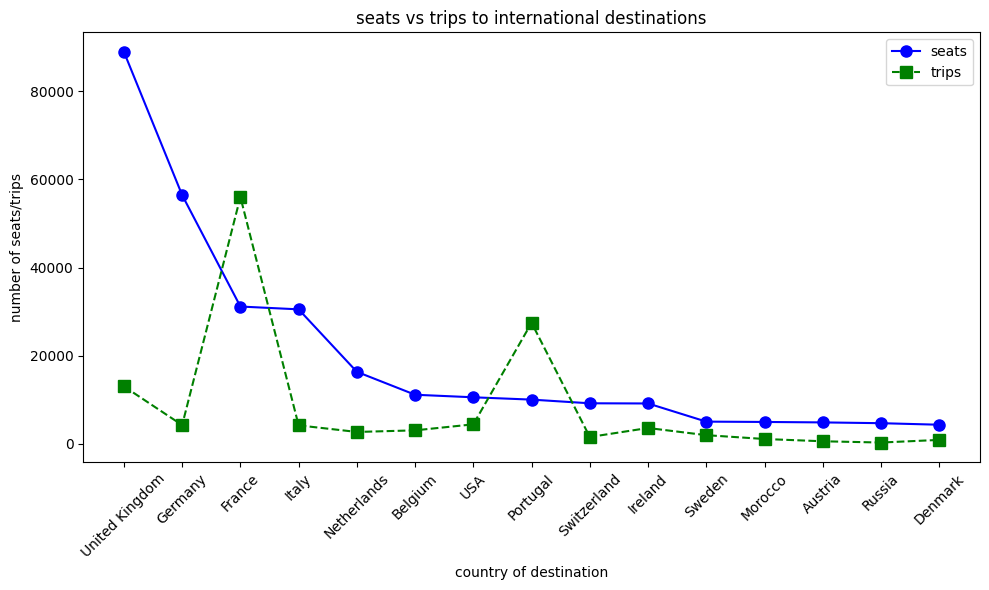

In [71]:
plt.figure(figsize=(10,6))

flights_per_country_outgoing_first15=flights_per_country_outgoing.head(15)

plt.plot(flights_per_country_outgoing_first15["country_destination"],flights_per_country_outgoing_first15["seats"],"bo-",label="seats",markersize=8)
plt.plot(flights_per_country_outgoing_first15["country_destination"],flights_per_country_outgoing_first15["trips"],"gs--",label="trips",markersize=8)

plt.xlabel("country of destination")
plt.ylabel("number of seats/trips")
plt.title("seats vs trips to international destinations")

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

# 4. Recalibration of the flights


In [72]:
coeffs_incoming=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\demand\incoming_trips_coefficients.csv")

In [73]:
coeffs_outgoing=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\demand\outgoing_trips_coefficients.csv")

In [74]:
coeffs_incoming

,origin,country_name_es,real_vs_predicted_coeff
0,GB,REINO UNIDO,5.590374
1,DE,ALEMANIA,8.355364
2,IT,ITALIA,3.881550
3,FR,FRANCIA,0.444651
4,NL,HOLANDA,4.887760
5,CH,SUIZA,8.230474
6,BE,BELGICA,2.684367
7,PT,PORTUGAL,0.408979
8,IE,IRLANDA,2.488044
9,US,ESTADOS UNIDOS,0.997730


In [75]:
flights_per_country_incoming=flights_per_country_incoming.sort_values(["seats"],ascending=False)
flights_per_country_outgoing=flights_per_country_outgoing.sort_values(["seats"],ascending=False)

In [76]:
new_flights_per_country_incoming=pd.merge(left=flights_per_country_incoming,left_on="origin_acronym",right=coeffs_incoming,right_on="origin",how="right")

In [77]:
new_flights_per_country_incoming=new_flights_per_country_incoming.drop(["origin","country_name_es"],axis=1)

In [78]:
new_flights_per_country_incoming["trips_recalculated"]=new_flights_per_country_incoming["trips"]*new_flights_per_country_incoming["real_vs_predicted_coeff"]

In [79]:
new_flights_per_country_incoming

,country_origin,country_destination,seats,origin_acronym,trips,real_vs_predicted_coeff,trips_recalculated
0,United Kingdom,Spain,89275,GB,14362.593,5.590374,80292.260504
1,Germany,Spain,56124,DE,5730.540,8.355364,47880.747808
2,Italy,Spain,30392,IT,7015.701,3.881550,27231.794568
3,France,Spain,31438,FR,44774.476,0.444651,19909.000634
4,Netherlands,Spain,16105,NL,2983.813,4.887760,14584.163194
5,Switzerland,Spain,9151,CH,1583.866,8.230474,13035.967780
6,Belgium,Spain,11523,BE,4190.503,2.684367,11248.849342
7,Portugal,Spain,10044,PT,21213.615,0.408979,8675.927568
8,Ireland,Spain,9146,IE,4328.649,2.488044,10769.869507
9,USA,Spain,10492,US,5515.558,0.997730,5503.038013


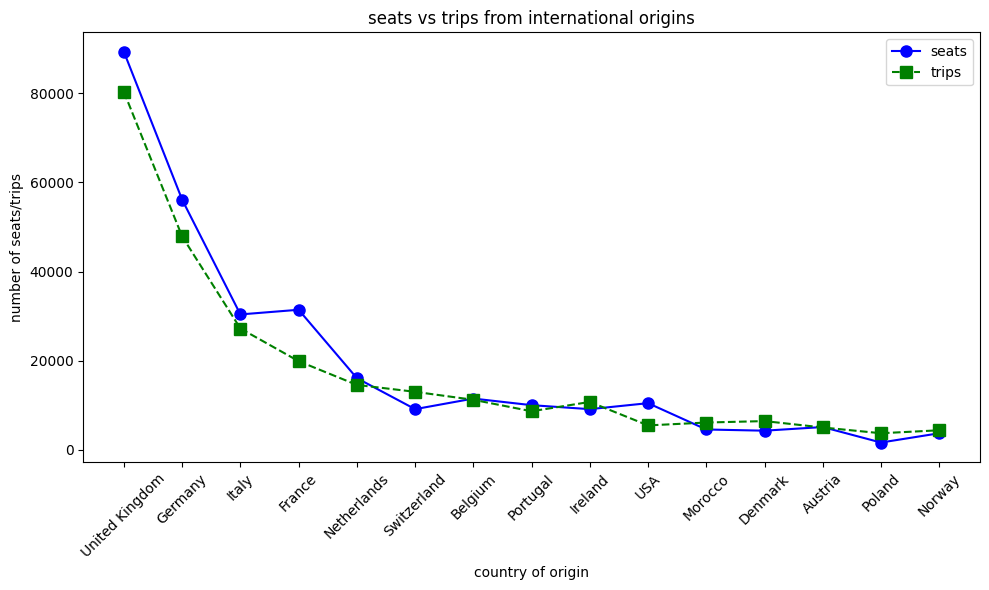

In [80]:
plt.figure(figsize=(10,6))


plt.plot(new_flights_per_country_incoming["country_origin"],new_flights_per_country_incoming["seats"],"bo-",label="seats",markersize=8)
plt.plot(new_flights_per_country_incoming["country_origin"],new_flights_per_country_incoming["trips_recalculated"],"gs--",label="trips",markersize=8)

plt.xlabel("country of origin")
plt.ylabel("number of seats/trips")
plt.title("seats vs trips from international origins")

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

In [81]:
new_flights_per_country_outgoing=pd.merge(left=flights_per_country_outgoing,left_on="destination_acronym",right=coeffs_outgoing,right_on="destination",how="right")

In [82]:
new_flights_per_country_outgoing=new_flights_per_country_outgoing.drop(["destination","country_name_es"],axis=1)

In [83]:
new_flights_per_country_outgoing["trips_recalculated"]=new_flights_per_country_outgoing["trips"]*new_flights_per_country_outgoing["real_vs_predicted_coeff"]

In [84]:
new_flights_per_country_outgoing

,country_origin,country_destination,seats,destination_acronym,trips,real_vs_predicted_coeff,trips_recalculated
0,Spain,United Kingdom,88954,GB,13017.612,5.231067,68096.000643
1,Spain,Germany,56441,DE,4239.057,11.244885,47667.706483
2,Spain,Italy,30510,IT,4175.500,5.286673,22074.504132
3,Spain,France,31147,FR,56012.453,0.465997,26101.616505
4,Spain,Netherlands,16329,NL,2679.481,5.409639,14495.024196
5,Spain,Switzerland,9186,CH,1533.972,9.739776,14940.544215
6,Spain,Belgium,11126,BE,3043.733,2.955786,8996.623072
7,Spain,Portugal,10021,PT,27449.514,0.422031,11584.542404
8,Spain,Ireland,9146,IE,3577.417,2.390679,8552.456777
9,Spain,USA,10548,US,4410.940,1.400174,6176.084096


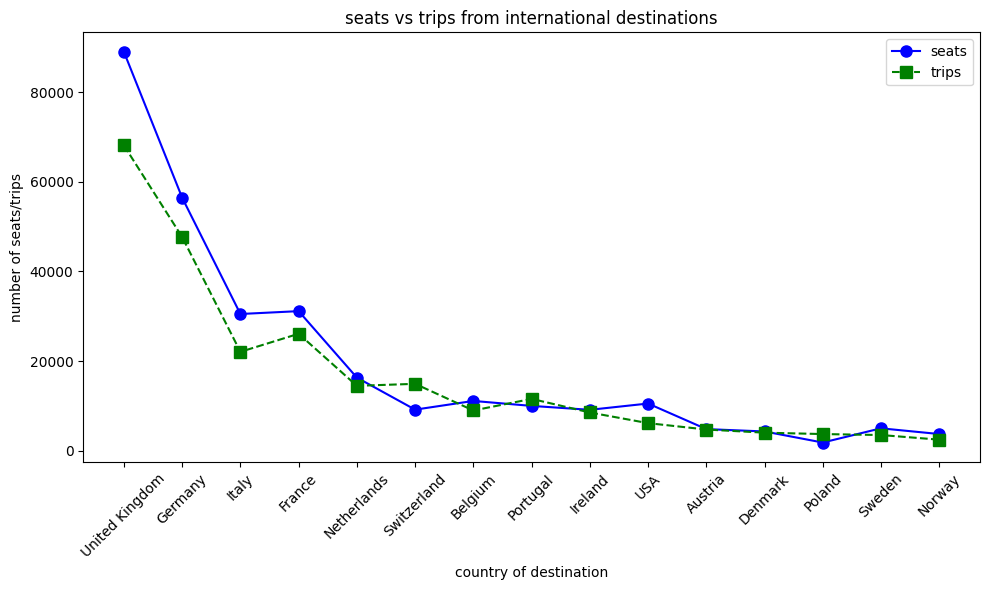

In [85]:
plt.figure(figsize=(10,6))


plt.plot(new_flights_per_country_outgoing["country_destination"],new_flights_per_country_outgoing["seats"],"bo-",label="seats",markersize=8)
plt.plot(new_flights_per_country_outgoing["country_destination"],new_flights_per_country_outgoing["trips_recalculated"],"gs--",label="trips",markersize=8)

plt.xlabel("country of destination")
plt.ylabel("number of seats/trips")
plt.title("seats vs trips from international destinations")

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

# 5. Infer the airport of the trips


We need to add the trips of the relevant countries to the demand (and remove the ones we do not want). Steps to follow:
- Find overlap between 15 countries of origin and 15 countries of destination
- Keep trips to those countries
- Assign airport of destination proportionally to the seats of that day. Do the assignation adding an airport (using ICAO) to the node-sequence reduced. Also change the corresponding origin/destination but not origin_name/destination_name . This will preserve information about the country and the airport but the column origin name will be a bit corrupted. (I do not want to be adding new columns in case we have to do another logit calibration)

FIRST PART EXTRACT THE PROPORTIONS OF SEATS FOR EACH AIRPORTS

In [86]:
trips_abroad

,date,origin,origin_name,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,legs,nationality,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,trips
0,20220923,AD,AD,ES512,Girona,airport_GRO,NaN,NF,NF,P17*abroad_213*17233_AM*None*airport_GRO*00-01...,AD,0.374079,0.668807,0.430757,0.022671,0.056679,0.034007,2,plane-road,airport_GRO,airport_GRO,airport_GRO,international_O,1,0,1,airport_GRO,airport_GRO,airport_GRO,['air'],1.587
1,20220923,AD,AD,ES512,Girona,airport_GRO,NaN,NF,NF,P20*abroad_213*17233_AM*None*airport_GRO*00-01...,AD,0.374079,0.668807,0.430757,0.022671,0.056679,0.034007,2,plane-road,airport_GRO,airport_GRO,airport_GRO,international_O,1,0,1,airport_GRO,airport_GRO,airport_GRO,['air'],1.587
2,20220923,AD,AD,ES514,Tarragona,airport_REU,NaN,NF,NF,P18*abroad_213*4312310_AD*None*airport_REU*00-...,AD,2.709353,3.928561,1.964281,0.406403,0.067734,0.338669,2,plane-road,airport_REU,airport_REU,airport_REU,international_O,1,0,1,airport_REU,airport_REU,airport_REU,['air'],9.415
3,20220923,AD,AD,ES514,Tarragona,airport_REU,NaN,NF,NF,P23*abroad_213*4312310_AD*None*airport_REU*00-...,AD,0.456691,0.662201,0.331101,0.068504,0.011417,0.057086,2,plane-road,airport_REU,airport_REU,airport_REU,international_O,1,0,1,airport_REU,airport_REU,airport_REU,['air'],1.587
4,20220923,AD,AD,ES523,Valencia / València,airport_VLC,NaN,NF,NF,P13*abroad_213*4615903*None*airport_VLC*00-01*...,AD,4.090123,3.279816,1.813545,0.000000,0.115758,0.115758,2,plane-road,airport_VLC,airport_VLC,airport_VLC,international_O,1,0,1,airport_VLC,airport_VLC,airport_VLC,['air'],9.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72720,20220923,ZA,ZA,ES300,Madrid,airport_MAD,NaN,NF,NF,P10*abroad_655*2807921*None*airport_MAD*00-01*...,ZA,2.200508,0.555165,0.660959,0.027204,0.123930,0.031234,2,plane-road,airport_MAD,airport_MAD,airport_MAD,international_O,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],3.599
72721,20220923,ZA,ZA,ES300,Madrid,airport_MAD,NaN,NF,NF,P19*abroad_655*2807921*None*airport_MAD*00-01*...,AR,5.411086,1.365160,1.625308,0.066895,0.304745,0.076806,2,plane-road,airport_MAD,airport_MAD,airport_MAD,international_O,1,0,1,airport_MAD,airport_MAD,airport_MAD,['air'],8.850
72722,20220923,ZA,ZA,ES511,Barcelona,airport_BCN,NaN,NF,NF,P07*abroad_655*0816904*None*airport_BCN*00-01*...,AR,1.372793,1.028286,0.975929,0.048168,0.104713,0.069111,4,plane-road-train-road,airport_BCN-train_72400-train_71801,airport_BCN,train_71801,international_O,2,1,1,airport_BCN,airport_BCN,airport_BCN,"['air', 'rail']",3.599
72723,20220923,ZA,ZA,ES511,Barcelona,airport_BCN,NaN,NF,NF,P13*abroad_655*0816904*None*airport_BCN*00-01*...,ZA,1.372793,1.028286,0.975929,0.048168,0.104713,0.069111,2,plane-road,airport_BCN,airport_BCN,airport_BCN,international_O,1,0,1,airport_BCN,airport_BCN,airport_BCN,['air'],3.599


In [87]:
countries_incoming=set(new_flights_per_country_incoming["origin_acronym"])

In [88]:
countries_outgoing=set(new_flights_per_country_outgoing["destination_acronym"])

In [89]:
countries_outgoing-countries_incoming

{'SE'}

In [90]:
countries_incoming-countries_outgoing

{'MA'}

In [91]:
countries_selected=set.union(countries_outgoing,countries_incoming)-(countries_outgoing-countries_incoming)-(countries_incoming-countries_outgoing)

if we remove morroco and sweden, all the countries match

In [92]:
flights_capacity.shape[0]

1932

In [93]:
country_to_acronym

{'Greece': 'GR',
 'Netherlands': 'NL',
 'Belgium': 'BE',
 'France': 'FR',
 'Monaco': 'MC',
 'Andorra': 'AD',
 'Spain': 'ES',
 'Hungary': 'HU',
 'Bosnia and Herzegovina': 'BA',
 'Croatia': 'HR',
 'Serbia': 'RS',
 'Italy': 'IT',
 'Romania': 'RO',
 'Switzerland': 'CH',
 'Czechia': 'CZ',
 'Slovakia': 'SK',
 'Austria': 'AT',
 'United Kingdom': 'GB',
 'Denmark': 'DK',
 'Sweden': 'SE',
 'Norway': 'NO',
 'Finland': 'FI',
 'Lithuania': 'LT',
 'Latvia': 'LV',
 'Estonia': 'EE',
 'Russian Federation': 'RU',
 'Ukraine': 'UA',
 'Belarus': 'BY',
 'Moldova': 'MD',
 'Poland': 'PL',
 'Germany': 'DE',
 'Gibraltar': 'GI',
 'Portugal': 'PT',
 'Luxembourg': 'LU',
 'Ireland': 'IE',
 'Iceland': 'IS',
 'Albania': 'AL',
 'Malta': 'MT',
 'Cyprus': 'CY',
 'Georgia': 'GE',
 'Armenia': 'AM',
 'Bulgaria': 'BG',
 'Turkey': 'TR',
 'Faroe Islands': 'FO',
 'Greenland': 'GL',
 'San Marino': 'SM',
 'Slovenia': 'SI',
 'North Macedonia': 'MK',
 'Liechtenstein': 'LI',
 'Montenegro': 'ME',
 'Canada': 'CA',
 'United States of 

In [94]:
country_names_selected={country: code for country, code in country_to_acronym.items() if code in countries_selected}

In [95]:
country_names_selected=set(country_names_selected)

In [96]:
country_names_selected.remove("United States of America")

In [97]:
country_names_selected.add("Spain")

In [98]:
country_names_selected.remove("Spain")

In [99]:
flights_capacity_selected=flights_capacity[(flights_capacity["country_origin"].isin(country_names_selected))|(flights_capacity["country_destination"].isin(country_names_selected))]

In [100]:
flights_capacity_selected["acronym_origin"]=flights_capacity_selected["country_origin"].map(country_to_acronym)
flights_capacity_selected["acronym_destination"]=flights_capacity_selected["country_destination"].map(country_to_acronym)

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_2020\2756728048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_capacity_selected["acronym_origin"]=flights_capacity_selected["country_origin"].map(country_to_acronym)
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_2020\2756728048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_capacity_selected["acronym_destination"]=flights_capacity_selected["country_destination"].map(country_to_acronym)


In [101]:
flights_capacity_selected

,origin,destination,seats,country_origin,country_destination,acronym_origin,acronym_destination
11,EBAW,LEIB,112,Belgium,Spain,BE,ES
12,EBAW,LEPA,112,Belgium,Spain,BE,ES
13,EBBR,GCLA,180,Belgium,Spain,BE,ES
14,EBBR,GCLP,180,Belgium,Spain,BE,ES
15,EBBR,GCTS,360,Belgium,Spain,BE,ES
...,...,...,...,...,...,...,...
1849,LSZH,LEMD,1199,Switzerland,Spain,CH,ES
1850,LSZH,LEMG,579,Switzerland,Spain,CH,ES
1851,LSZH,LEPA,1082,Switzerland,Spain,CH,ES
1852,LSZH,LEVC,360,Switzerland,Spain,CH,ES


In [102]:
#create dictionaries with the seats per airports and country

seats_from={}
seats_to={}
for _,row in flights_capacity_selected.iterrows():
    if row["country_destination"]=="Spain":
        airport=row["destination"]
        country=row["acronym_origin"]
        if airport not in seats_from.keys():
            seats_from[airport]={country:row["seats"]}
        else:
            dict=seats_from[airport]
            if country not in dict.keys():
                dict[country]=row["seats"]
            else:
                dict[country]+=row["seats"]
    else:
        airport=row["origin"]
        country=row["acronym_destination"]
        if airport not in seats_to.keys():
            seats_to[airport]={country:row["seats"]}
        else:
            dict=seats_to[airport]
            if country not in dict.keys():
                dict[country]=row["seats"]
            else:
                dict[country]+=row["seats"]

In [103]:
seats_to

{'GCFV': {'DE': 1525, 'GB': 598, 'FR': 186},
 'GCLA': {'NL': 149},
 'GCLP': {'BE': 360,
  'DE': 1125,
  'GB': 1541,
  'NL': 567,
  'IE': 401,
  'NO': 372,
  'FR': 409,
  'IT': 378,
  'PT': 178,
  'CH': 174},
 'GCRR': {'DE': 1906, 'GB': 2677, 'IE': 764, 'DK': 212, 'FR': 189},
 'GCTS': {'BE': 729,
  'DE': 2015,
  'GB': 9683,
  'NL': 756,
  'IE': 552,
  'PL': 189,
  'FR': 189,
  'IT': 567,
  'PT': 144,
  'CH': 174},
 'GCXO': {'PT': 72},
 'LEAL': {'BE': 1809,
  'DE': 2010,
  'GB': 11812,
  'NL': 1881,
  'IE': 915,
  'DK': 561,
  'NO': 1302,
  'FR': 1605,
  'IT': 927,
  'PT': 70,
  'CH': 186},
 'LEAM': {'BE': 189, 'GB': 706},
 'LEAS': {'DE': 125, 'GB': 180},
 'LEBB': {'BE': 282,
  'DE': 1456,
  'GB': 1012,
  'NL': 342,
  'IE': 174,
  'FR': 945,
  'IT': 516,
  'AT': 180,
  'PT': 500},
 'LEBL': {'BE': 1842,
  'DE': 7725,
  'GB': 8957,
  'NL': 3374,
  'IE': 1269,
  'DK': 964,
  'NO': 744,
  'PL': 378,
  'US': 3988,
  'FR': 9578,
  'IT': 10282,
  'AT': 1266,
  'PT': 3141,
  'CH': 2677},
 'LECH'

In [104]:
# seats_from={}
# seats_to={}
# for  _,row in flights_capacity_selected.iterrows():
#     if row["origin"] not in seats_from.keys():
#         seats_from[row["origin"]]=row["seats"]
#     elif row["origin"] in seats_from.keys():
#         seats_from[row["origin"]]+=row["seats"]
    
#     if row["destination"] not in seats_to.keys():
#         seats_to[row["destination"]]=row["seats"]
#     elif row["destination"] in seats_to.keys():
#         seats_to[row["destination"]]+=row["seats"]

In [105]:
seats_from

{'LEIB': {'BE': 112,
  'DE': 1472,
  'GB': 5666,
  'NL': 1416,
  'FR': 924,
  'IT': 2043,
  'AT': 180,
  'CH': 319},
 'LEPA': {'BE': 629,
  'DE': 23953,
  'GB': 13225,
  'NL': 1637,
  'IE': 915,
  'DK': 729,
  'NO': 392,
  'FR': 2313,
  'IT': 1033,
  'AT': 1800,
  'PT': 180,
  'CH': 1524},
 'GCLA': {'BE': 180, 'NL': 149},
 'GCLP': {'BE': 180,
  'DE': 1125,
  'GB': 1541,
  'NL': 756,
  'IE': 401,
  'NO': 372,
  'FR': 409,
  'IT': 378,
  'PT': 178,
  'CH': 174},
 'GCTS': {'BE': 729,
  'DE': 2015,
  'GB': 9680,
  'NL': 567,
  'IE': 552,
  'FR': 189,
  'IT': 567,
  'PT': 144,
  'CH': 174},
 'LEAL': {'BE': 1809,
  'DE': 2010,
  'GB': 12040,
  'NL': 1881,
  'IE': 915,
  'DK': 561,
  'NO': 1302,
  'FR': 1605,
  'IT': 927,
  'PT': 70,
  'CH': 186},
 'LEBB': {'BE': 282,
  'DE': 1456,
  'GB': 1010,
  'NL': 342,
  'IE': 174,
  'FR': 1109,
  'IT': 516,
  'AT': 180,
  'PT': 500},
 'LEBL': {'BE': 1842,
  'DE': 7963,
  'GB': 8957,
  'NL': 3002,
  'IE': 1269,
  'DK': 964,
  'NO': 744,
  'PL': 378,
  '

In [106]:
for key, dict in seats_from.items():
    total=sum(value for k,value in dict.items() if k !="total")
    dict["total"]=total


In [107]:
for key, dict in seats_to.items():
    total=sum(value for k,value in dict.items() if k !="total")
    dict["total"]=total

In [108]:
flights_per_country=flights_per_country.rename({"seats":"total_seats"},axis=1)

In [109]:
flights_per_country

,country_origin,country_destination,total_seats
140,United Kingdom,Spain,89275
129,Spain,United Kingdom,88954
84,Spain,Germany,56441
26,Germany,Spain,56124
24,France,Spain,31438
...,...,...,...
34,Jordan,Spain,133
9,Cape Verde,Spain,100
66,Spain,Cape Verde,100
41,Mauritania,Spain,75


In [110]:
# flights_capacity_selected=pd.merge(left=flights_capacity_selected,left_on=["country_origin","country_destination"],right=flights_per_country,right_on=["country_origin","country_destination"],how="left")

In [111]:
# flights_capacity_selected=flights_capacity_selected.drop(["total_seats"],axis=1)

In [112]:
# flights_capacity_selected

In [113]:
# flights_capacity_selected["total_seats_origin"]=flights_capacity_selected["origin"].map(seats_from)

In [114]:
# flights_capacity_selected["total_seats_destination"]=flights_capacity_selected["destination"].map(seats_to)

In [115]:
# flights_capacity_selected["seats_proportion_origin"]=flights_capacity_selected["seats"]/flights_capacity_selected["total_seats_origin"]
# flights_capacity_selected["seats_proportion_destination"]=flights_capacity_selected["seats"]/flights_capacity_selected["total_seats_destination"]

In [116]:
coeffs_incoming

,origin,country_name_es,real_vs_predicted_coeff
0,GB,REINO UNIDO,5.590374
1,DE,ALEMANIA,8.355364
2,IT,ITALIA,3.881550
3,FR,FRANCIA,0.444651
4,NL,HOLANDA,4.887760
5,CH,SUIZA,8.230474
6,BE,BELGICA,2.684367
7,PT,PORTUGAL,0.408979
8,IE,IRLANDA,2.488044
9,US,ESTADOS UNIDOS,0.997730


SECOND PART: FORMAT THE TRIPS AGAIN

In [117]:
trips_abroad_rescaled=rescale_trips(trips_abroad,coeffs_incoming,coeffs_outgoing)

In [118]:
trips_abroad_rescaled[trips_abroad_rescaled["origin"]=="FR"]

,date,origin,origin_name,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,legs,nationality,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,trips
43395,20220923,FR,FR,ES111,A Coruña,airport_BCN,NaN,NF,H,P18*FR107*0816904*None*airport_BCN*00-01*plane...,ES,1.107774,1.035212,0.459557,0.077399,0.053212,0.149961,4,plane-road-bus-road,airport_BCN-bus_3503-bus_1166,airport_BCN,bus_1166,international_O,2,0,1,airport_BCN-bus_3503-bus_1166,airport_BCN,bus_1166,['air'],2.883115
43396,20220923,FR,FR,ES111,A Coruña,airport_BCN,NaN,NF,NF,P07*FRK26*0816904*None*airport_BCN*00-01*plane...,ES,0.694540,0.549478,0.356062,0.035167,0.030771,0.030771,3,plane-plane-road,airport_BCN-airport_LCG,airport_BCN,airport_LCG,international_O,1,0,2,airport_BCN-airport_LCG,airport_BCN,airport_LCG,"['air', 'air']",1.696787
43397,20220923,FR,FR,ES111,A Coruña,airport_BCN,NaN,NF,O,P07*FRD22*0816904*None*airport_BCN*00-01*plane...,ES,1.142988,0.986258,0.531356,0.091745,0.030582,0.110858,3,plane-plane-road,airport_BCN-airport_SCQ,airport_BCN,airport_SCQ,international_O,1,0,2,airport_BCN-airport_SCQ,airport_BCN,airport_SCQ,"['air', 'air']",2.893787
43398,20220923,FR,FR,ES111,A Coruña,airport_LCG,NaN,NF,H,P07*FRI15*1503103*None*airport_LCG*00-01*plane...,ES,0.545220,0.526420,0.202108,0.065802,0.032901,0.061102,2,plane-road,airport_LCG,airport_LCG,airport_LCG,international_O,1,0,1,airport_LCG,airport_LCG,airport_LCG,['air'],1.433554
43399,20220923,FR,FR,ES111,A Coruña,airport_LCG,NaN,NF,H,P08*FRL03*1503103*None*airport_LCG*00-01*plane...,ES,0.817529,0.481558,0.375167,0.033597,0.050396,0.016799,2,plane-road,airport_LCG,airport_LCG,airport_LCG,international_O,1,0,1,airport_LCG,airport_LCG,airport_LCG,['air'],1.775045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57479,20220923,FR,FR,ES709,Tenerife,airport_MAD,NaN,NF,NF,P06*FRD11*2807921*None*airport_MAD*00-01*plane...,ES,0.265358,0.486490,0.280100,0.014742,0.036855,0.014742,3,plane-plane-road,airport_MAD-airport_TFN,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",1.098287
57480,20220923,FR,FR,ES709,Tenerife,airport_MAD,NaN,NF,NF,P10*abroad_208*2807921*None*airport_MAD*00-01*...,FR,0.107320,0.348791,0.174395,0.013415,0.040245,0.026830,5,plane-road-plane-plane-road,airport_MAD-airport_VLC-airport_MAD-airport_TFN,airport_MAD,airport_TFN,international_O,2,0,3,airport_MAD-airport_VLC-airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air', 'air']",0.710996
57481,20220923,FR,FR,ES709,Tenerife,airport_SCQ,NaN,NF,NF,P06*FRI12*1507806*None*airport_SCQ*00-01*plane...,ES,0.096045,0.106716,0.060472,0.008893,0.003557,0.005336,3,plane-plane-road,airport_SCQ-airport_TFN,airport_SCQ,airport_TFN,international_O,1,0,2,airport_SCQ-airport_TFN,airport_SCQ,airport_TFN,"['air', 'air']",0.281019
57482,20220923,FR,FR,ES709,Tenerife,airport_SCQ,NaN,NF,NF,P09*FRI12*1507806*None*airport_SCQ*00-01*plane...,ES,0.138141,0.191615,0.053474,0.008912,0.008912,0.008912,3,plane-plane-road,airport_SCQ-airport_TFN,airport_SCQ,airport_TFN,international_O,1,0,2,airport_SCQ-airport_TFN,airport_SCQ,airport_TFN,"['air', 'air']",0.409968


I want to reduce this to only the selected countries first

In [119]:
trips_abroad_rescaled[~trips_abroad_rescaled["origin"].str.startswith("ES")]["origin"].value_counts()

origin
FR    14089
PT     5847
IT     1196
US     1188
BE     1021
      ...  
KH        1
SV        1
SY        1
TT        1
UZ        1
Name: count, Length: 108, dtype: int64

In [120]:
trips_abroad_rescaled_selected=trips_abroad_rescaled[(trips_abroad_rescaled["origin"].isin(countries_selected))|(trips_abroad_rescaled["destination"].isin(countries_selected))]

In [121]:
trips_abroad_rescaled_selected["trips"].sum()

np.float64(502524.45973816677)

In [122]:
trips_abroad_rescaled_selected.shape[0]

63610

In [123]:
trips_abroad_rescaled_selected=trips_abroad_rescaled_selected.drop(["origin_purpose","destination_purpose","legs","nationality"],axis=1)

In [124]:
groupby_columns=["origin","origin_name","destination","destination_name","entry_point","exit_point","n_legs","mode_sequence","start_node","end_node","type","road_legs","train_legs","plane_legs","node_sequence_reduced","start_node_reduced","end_node_reduced","mode_tp"]

In [125]:
trips_abroad_rescaled_selected=trips_abroad_rescaled_selected.groupby(groupby_columns,as_index=False,dropna=False).sum()

In [126]:
trips_abroad_rescaled_selected["trips"].sum()

np.float64(502524.45973816677)

why empty???


In [127]:
trips_abroad_rescaled_selected.shape[0]

4758

In [128]:
trips_abroad_rescaled_selected

,origin,origin_name,destination,destination_name,entry_point,exit_point,n_legs,mode_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,date,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,node_sequence,trips
0,AT,AT,ES111,A Coruña,airport_LCG,NaN,2,plane-road,airport_LCG,airport_LCG,international_O,1,0,1,airport_LCG,airport_LCG,airport_LCG,['air'],20220923,25.429960,19.375208,12.311330,2.220076,1.614601,1.412776,airport_LCG,62.363950
1,AT,AT,ES114,Pontevedra,airport_VGO,NaN,2,plane-road,airport_VGO,airport_VGO,international_O,1,0,1,airport_VGO,airport_VGO,airport_VGO,['air'],20220923,4.672052,3.270437,1.635218,0.233603,0.467205,0.233603,airport_VGO,10.512118
2,AT,AT,ES120,Asturias,airport_VIT,NaN,2,plane-road,airport_VIT,airport_VIT,international_O,1,0,1,airport_VIT,airport_VIT,airport_VIT,['air'],20220923,4.140809,2.581916,1.510177,0.487154,0.194862,0.292292,airport_VIT,9.207211
3,AT,AT,ES120,Asturias,airport_VIT,NaN,4,plane-road-bus-road,airport_VIT,bus_2222,international_O,2,0,1,airport_VIT-bus_19-bus_2222,airport_VIT,bus_2222,['air'],20220923,0.586863,0.365926,0.214032,0.069043,0.027617,0.041426,airport_VIT-bus_19-bus_2222,1.304907
4,AT,AT,ES130,Cantabria,airport_SDR,NaN,2,plane-road,airport_SDR,airport_SDR,international_O,1,0,1,airport_SDR,airport_SDR,airport_SDR,['air'],141546461,47.701263,54.768117,15.900421,1.766713,1.766713,3.533427,airport_SDRairport_SDRairport_SDRairport_SDRai...,125.436656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,US,US,ES618,Sevilla,airport_SVQ,NaN,2,plane-road,airport_SVQ,airport_SVQ,international_O,1,0,1,airport_SVQ,airport_SVQ,airport_SVQ,['air'],242651076,28.082771,4.853812,14.214736,1.386803,1.386803,0.346701,airport_SVQairport_SVQairport_SVQairport_SVQai...,50.271627
4754,US,US,ES618,Sevilla,airport_VLC,NaN,3,plane-plane-road,airport_VLC,airport_SVQ,international_O,1,0,2,airport_VLC-airport_SVQ,airport_VLC,airport_SVQ,"['air', 'air']",20220923,2.005912,0.346701,1.015338,0.099057,0.099057,0.024764,airport_VLC-airport_SVQ,3.590830
4755,US,US,ES620,Murcia,airport_ALC,NaN,2,plane-road,airport_ALC,airport_ALC,international_O,1,0,1,airport_ALC,airport_ALC,airport_ALC,['air'],222430153,39.499135,14.363322,0.000000,0.000000,0.000000,0.000000,airport_ALCairport_ALCairport_ALCairport_ALCai...,53.862457
4756,US,US,ES620,Murcia,airport_ALC,NaN,4,plane-road-train-road,airport_ALC,train_61200,international_O,2,1,1,airport_ALC-train_62104-train_61200,airport_ALC,train_61200,"['air', 'rail']",20220923,2.633276,0.957555,0.000000,0.000000,0.000000,0.000000,airport_ALC-train_62104-train_61200,3.590830


In [129]:
flights_capacity_selected

,origin,destination,seats,country_origin,country_destination,acronym_origin,acronym_destination
11,EBAW,LEIB,112,Belgium,Spain,BE,ES
12,EBAW,LEPA,112,Belgium,Spain,BE,ES
13,EBBR,GCLA,180,Belgium,Spain,BE,ES
14,EBBR,GCLP,180,Belgium,Spain,BE,ES
15,EBBR,GCTS,360,Belgium,Spain,BE,ES
...,...,...,...,...,...,...,...
1849,LSZH,LEMD,1199,Switzerland,Spain,CH,ES
1850,LSZH,LEMG,579,Switzerland,Spain,CH,ES
1851,LSZH,LEPA,1082,Switzerland,Spain,CH,ES
1852,LSZH,LEVC,360,Switzerland,Spain,CH,ES


In [130]:
trips_example=trips_abroad_rescaled_selected[~trips_abroad_rescaled_selected["origin"].str.startswith("ES")]

In [131]:
trips_example

,origin,origin_name,destination,destination_name,entry_point,exit_point,n_legs,mode_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,date,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,node_sequence,trips
0,AT,AT,ES111,A Coruña,airport_LCG,NaN,2,plane-road,airport_LCG,airport_LCG,international_O,1,0,1,airport_LCG,airport_LCG,airport_LCG,['air'],20220923,25.429960,19.375208,12.311330,2.220076,1.614601,1.412776,airport_LCG,62.363950
1,AT,AT,ES114,Pontevedra,airport_VGO,NaN,2,plane-road,airport_VGO,airport_VGO,international_O,1,0,1,airport_VGO,airport_VGO,airport_VGO,['air'],20220923,4.672052,3.270437,1.635218,0.233603,0.467205,0.233603,airport_VGO,10.512118
2,AT,AT,ES120,Asturias,airport_VIT,NaN,2,plane-road,airport_VIT,airport_VIT,international_O,1,0,1,airport_VIT,airport_VIT,airport_VIT,['air'],20220923,4.140809,2.581916,1.510177,0.487154,0.194862,0.292292,airport_VIT,9.207211
3,AT,AT,ES120,Asturias,airport_VIT,NaN,4,plane-road-bus-road,airport_VIT,bus_2222,international_O,2,0,1,airport_VIT-bus_19-bus_2222,airport_VIT,bus_2222,['air'],20220923,0.586863,0.365926,0.214032,0.069043,0.027617,0.041426,airport_VIT-bus_19-bus_2222,1.304907
4,AT,AT,ES130,Cantabria,airport_SDR,NaN,2,plane-road,airport_SDR,airport_SDR,international_O,1,0,1,airport_SDR,airport_SDR,airport_SDR,['air'],141546461,47.701263,54.768117,15.900421,1.766713,1.766713,3.533427,airport_SDRairport_SDRairport_SDRairport_SDRai...,125.436656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,US,US,ES618,Sevilla,airport_SVQ,NaN,2,plane-road,airport_SVQ,airport_SVQ,international_O,1,0,1,airport_SVQ,airport_SVQ,airport_SVQ,['air'],242651076,28.082771,4.853812,14.214736,1.386803,1.386803,0.346701,airport_SVQairport_SVQairport_SVQairport_SVQai...,50.271627
4754,US,US,ES618,Sevilla,airport_VLC,NaN,3,plane-plane-road,airport_VLC,airport_SVQ,international_O,1,0,2,airport_VLC-airport_SVQ,airport_VLC,airport_SVQ,"['air', 'air']",20220923,2.005912,0.346701,1.015338,0.099057,0.099057,0.024764,airport_VLC-airport_SVQ,3.590830
4755,US,US,ES620,Murcia,airport_ALC,NaN,2,plane-road,airport_ALC,airport_ALC,international_O,1,0,1,airport_ALC,airport_ALC,airport_ALC,['air'],222430153,39.499135,14.363322,0.000000,0.000000,0.000000,0.000000,airport_ALCairport_ALCairport_ALCairport_ALCai...,53.862457
4756,US,US,ES620,Murcia,airport_ALC,NaN,4,plane-road-train-road,airport_ALC,train_61200,international_O,2,1,1,airport_ALC-train_62104-train_61200,airport_ALC,train_61200,"['air', 'rail']",20220923,2.633276,0.957555,0.000000,0.000000,0.000000,0.000000,airport_ALC-train_62104-train_61200,3.590830


In [132]:
airport_codes=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain+abroad\v=0.1\infrastructure\airports_info\IATA_ICAO_Airport_codes_v1.3.csv")

In [133]:
iata_to_icao=airport_codes.set_index("IATA")["ICAO"].to_dict()

In [134]:
trips_example["entry_point"]=trips_example["entry_point"].apply(lambda x: format_airports(x,iata_to_icao))

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_2020\773229502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_example["entry_point"]=trips_example["entry_point"].apply(lambda x: format_airports(x,iata_to_icao))


In [135]:
flights_capacity_selected

,origin,destination,seats,country_origin,country_destination,acronym_origin,acronym_destination
11,EBAW,LEIB,112,Belgium,Spain,BE,ES
12,EBAW,LEPA,112,Belgium,Spain,BE,ES
13,EBBR,GCLA,180,Belgium,Spain,BE,ES
14,EBBR,GCLP,180,Belgium,Spain,BE,ES
15,EBBR,GCTS,360,Belgium,Spain,BE,ES
...,...,...,...,...,...,...,...
1849,LSZH,LEMD,1199,Switzerland,Spain,CH,ES
1850,LSZH,LEMG,579,Switzerland,Spain,CH,ES
1851,LSZH,LEPA,1082,Switzerland,Spain,CH,ES
1852,LSZH,LEVC,360,Switzerland,Spain,CH,ES


In [136]:
trips_example_merged=pd.merge(left=trips_example, left_on=["origin","entry_point"],right=flights_capacity_selected,right_on=["acronym_origin","destination"],how="left")

In [137]:
trips_example_merged

,origin_x,origin_name,destination_x,destination_name,entry_point,exit_point,n_legs,mode_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,date,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,node_sequence,trips,origin_y,destination_y,seats,country_origin,country_destination,acronym_origin,acronym_destination
0,AT,AT,ES111,A Coruña,LECO,NaN,2,plane-road,airport_LCG,airport_LCG,international_O,1,0,1,airport_LCG,airport_LCG,airport_LCG,['air'],20220923,25.429960,19.375208,12.311330,2.220076,1.614601,1.412776,airport_LCG,62.363950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT,AT,ES114,Pontevedra,LEVX,NaN,2,plane-road,airport_VGO,airport_VGO,international_O,1,0,1,airport_VGO,airport_VGO,airport_VGO,['air'],20220923,4.672052,3.270437,1.635218,0.233603,0.467205,0.233603,airport_VGO,10.512118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AT,AT,ES120,Asturias,LEVT,NaN,2,plane-road,airport_VIT,airport_VIT,international_O,1,0,1,airport_VIT,airport_VIT,airport_VIT,['air'],20220923,4.140809,2.581916,1.510177,0.487154,0.194862,0.292292,airport_VIT,9.207211,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AT,AT,ES120,Asturias,LEVT,NaN,4,plane-road-bus-road,airport_VIT,bus_2222,international_O,2,0,1,airport_VIT-bus_19-bus_2222,airport_VIT,bus_2222,['air'],20220923,0.586863,0.365926,0.214032,0.069043,0.027617,0.041426,airport_VIT-bus_19-bus_2222,1.304907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AT,AT,ES130,Cantabria,LEXJ,NaN,2,plane-road,airport_SDR,airport_SDR,international_O,1,0,1,airport_SDR,airport_SDR,airport_SDR,['air'],141546461,47.701263,54.768117,15.900421,1.766713,1.766713,3.533427,airport_SDRairport_SDRairport_SDRairport_SDRai...,125.436656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11806,US,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",40441846,1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,7.181661,KLAX,LEMD,288.0,USA,Spain,US,ES
11807,US,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",40441846,1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,7.181661,KMIA,LEMD,1276.0,USA,Spain,US,ES
11808,US,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",40441846,1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,7.181661,KORD,LEMD,348.0,USA,Spain,US,ES
11809,US,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",40441846,1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,7.181661,KPHL,LEMD,247.0,USA,Spain,US,ES


The plan is to merge the two dataframes and then apply the proportionality coefficient

In [138]:
flights_capacity_selected[(flights_capacity_selected["country_origin"]=="Austria")&(flights_capacity_selected["destination"]=="LECO")]

,origin,destination,seats,country_origin,country_destination,acronym_origin,acronym_destination


some trips do not have associated schedules

In [139]:
trips_example_merged[trips_example_merged["origin_y"].isna()]["trips"].sum()

np.float64(8715.983918599635)

In [140]:
trips_example["trips"].sum()

np.float64(258803.46661240148)

In [141]:
trips_example_merged["trips"].sum()

np.float64(2308021.5779597056)

In [142]:
trips_example_merged=trips_example_merged.rename({"origin_x":"origin"},axis=1)

In [143]:
trips_example_merged["origin"]=trips_example_merged["origin_y"].fillna(trips_example_merged["origin"])

In [144]:
trips_example_merged=trips_example_merged.drop(["origin_y"],axis=1)

In [145]:
trips_example_merged=trips_example_merged.drop(["date"],axis=1)

In [146]:
trips_example_merged["proportionality_coeff"]=1

In [147]:
trips_example_merged

,origin,origin_name,destination_x,destination_name,entry_point,exit_point,n_legs,mode_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,node_sequence,trips,destination_y,seats,country_origin,country_destination,acronym_origin,acronym_destination,proportionality_coeff
0,AT,AT,ES111,A Coruña,LECO,NaN,2,plane-road,airport_LCG,airport_LCG,international_O,1,0,1,airport_LCG,airport_LCG,airport_LCG,['air'],25.429960,19.375208,12.311330,2.220076,1.614601,1.412776,airport_LCG,62.363950,NaN,NaN,NaN,NaN,NaN,NaN,1
1,AT,AT,ES114,Pontevedra,LEVX,NaN,2,plane-road,airport_VGO,airport_VGO,international_O,1,0,1,airport_VGO,airport_VGO,airport_VGO,['air'],4.672052,3.270437,1.635218,0.233603,0.467205,0.233603,airport_VGO,10.512118,NaN,NaN,NaN,NaN,NaN,NaN,1
2,AT,AT,ES120,Asturias,LEVT,NaN,2,plane-road,airport_VIT,airport_VIT,international_O,1,0,1,airport_VIT,airport_VIT,airport_VIT,['air'],4.140809,2.581916,1.510177,0.487154,0.194862,0.292292,airport_VIT,9.207211,NaN,NaN,NaN,NaN,NaN,NaN,1
3,AT,AT,ES120,Asturias,LEVT,NaN,4,plane-road-bus-road,airport_VIT,bus_2222,international_O,2,0,1,airport_VIT-bus_19-bus_2222,airport_VIT,bus_2222,['air'],0.586863,0.365926,0.214032,0.069043,0.027617,0.041426,airport_VIT-bus_19-bus_2222,1.304907,NaN,NaN,NaN,NaN,NaN,NaN,1
4,AT,AT,ES130,Cantabria,LEXJ,NaN,2,plane-road,airport_SDR,airport_SDR,international_O,1,0,1,airport_SDR,airport_SDR,airport_SDR,['air'],47.701263,54.768117,15.900421,1.766713,1.766713,3.533427,airport_SDRairport_SDRairport_SDRairport_SDRai...,125.436656,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11806,KLAX,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,7.181661,LEMD,288.0,USA,Spain,US,ES,1
11807,KMIA,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,7.181661,LEMD,1276.0,USA,Spain,US,ES,1
11808,KORD,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,7.181661,LEMD,348.0,USA,Spain,US,ES,1
11809,KPHL,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,7.181661,LEMD,247.0,USA,Spain,US,ES,1


In [148]:
seats_from["LECO"]

{'GB': 180, 'total': 180}

In [149]:
for idx,row in trips_example_merged.iterrows():
    if row["entry_point"] in seats_from:
        if row["origin_name"] in seats_from[row["entry_point"]]:
            coeff=row["seats"]/seats_from[row["entry_point"]][row["origin_name"]]

            trips_example_merged.at[idx, "proportionality_coeff"]=coeff

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_2020\2265051472.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3247422680412371' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trips_example_merged.at[idx, "proportionality_coeff"]=coeff


In [150]:
trips_example_merged["trips"]=trips_example_merged["trips"]*trips_example_merged["proportionality_coeff"]

In [151]:
trips_example_merged["trips"].sum()

np.float64(258803.46661240145)

In [152]:
trips_example["trips"].sum()

np.float64(258803.46661240148)

yesssssss

In [153]:
trips_example_merged

,origin,origin_name,destination_x,destination_name,entry_point,exit_point,n_legs,mode_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,node_sequence,trips,destination_y,seats,country_origin,country_destination,acronym_origin,acronym_destination,proportionality_coeff
0,AT,AT,ES111,A Coruña,LECO,NaN,2,plane-road,airport_LCG,airport_LCG,international_O,1,0,1,airport_LCG,airport_LCG,airport_LCG,['air'],25.429960,19.375208,12.311330,2.220076,1.614601,1.412776,airport_LCG,62.363950,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1,AT,AT,ES114,Pontevedra,LEVX,NaN,2,plane-road,airport_VGO,airport_VGO,international_O,1,0,1,airport_VGO,airport_VGO,airport_VGO,['air'],4.672052,3.270437,1.635218,0.233603,0.467205,0.233603,airport_VGO,10.512118,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2,AT,AT,ES120,Asturias,LEVT,NaN,2,plane-road,airport_VIT,airport_VIT,international_O,1,0,1,airport_VIT,airport_VIT,airport_VIT,['air'],4.140809,2.581916,1.510177,0.487154,0.194862,0.292292,airport_VIT,9.207211,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
3,AT,AT,ES120,Asturias,LEVT,NaN,4,plane-road-bus-road,airport_VIT,bus_2222,international_O,2,0,1,airport_VIT-bus_19-bus_2222,airport_VIT,bus_2222,['air'],0.586863,0.365926,0.214032,0.069043,0.027617,0.041426,airport_VIT-bus_19-bus_2222,1.304907,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
4,AT,AT,ES130,Cantabria,LEXJ,NaN,2,plane-road,airport_SDR,airport_SDR,international_O,1,0,1,airport_SDR,airport_SDR,airport_SDR,['air'],47.701263,54.768117,15.900421,1.766713,1.766713,3.533427,airport_SDRairport_SDRairport_SDRairport_SDRai...,125.436656,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11806,KLAX,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,0.318007,LEMD,288.0,USA,Spain,US,ES,0.044280
11807,KMIA,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,1.408948,LEMD,1276.0,USA,Spain,US,ES,0.196187
11808,KORD,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,0.384259,LEMD,348.0,USA,Spain,US,ES,0.053506
11809,KPHL,US,ES709,Tenerife,LEMD,NaN,3,plane-plane-road,airport_MAD,airport_TFN,international_O,1,0,2,airport_MAD-airport_TFN,airport_MAD,airport_TFN,"['air', 'air']",1.084024,3.523079,1.761539,0.135503,0.406509,0.271006,airport_MAD-airport_TFNairport_MAD-airport_TFN,0.272735,LEMD,247.0,USA,Spain,US,ES,0.037977
